# Possion Problem I

Considering the following Poisson equation
\begin{equation}
\begin{aligned}
- \Delta u &= f   &&\quad{\rm in}\quad \Omega,\\
         u &= g_D &&\quad{\rm on} \quad \partial\Omega_D, \\
         \frac{\partial u}{\partial n} &= g_N &&\quad{\rm on} \quad \partial\Omega_N,
\end{aligned}
\end{equation}
where $\partial\Omega_D\cap\partial\Omega_N = \partial\Omega$, and $\int_{\partial\Omega_D} {\rm d}s \ne 0$.

Define __trial__ and __test__ function space

\begin{equation}
\begin{aligned}
H_E^1 &:= \{u \in H^1 \,|\, u = g_D \ \ \text{on}\ \ \partial\Omega_D\},\\
H^1_{E_0} &:= \{u \in H^1 \,|\, u = 0 \ \ \text{on}\ \ \partial\Omega_D\}\\
\end{aligned}
\end{equation}

The __variational form__ is

Find $u \in H_E^1$, such that
\begin{equation}
    \int_\Omega \nabla u\cdot\nabla v = \int_\Omega f v + \int_{\partial\Omega_N} g_N v \qquad \forall v \in H^1_{E_0}.
\end{equation}

## A simple example

Now, we solve possion problem in domain $\Omega = (0, 1)\times(0, 1)$.

Assume $\partial\Omega_N = \emptyset, \partial\Omega_D = \partial\Omega$ and $g_D = 0$ (homogeneous Dirichlet boundary condition).

In addition, let the source term be $f = \sin(\pi x)\sin(\pi y)$. 

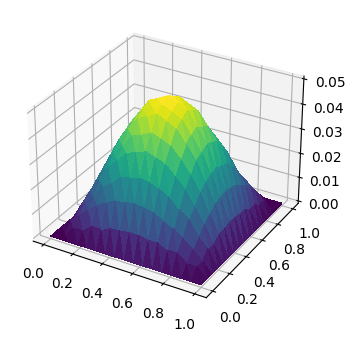

In [25]:
from firedrake import *                             # Import firedrake
import matplotlib.pyplot as plt

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)   # Build mesh on the domain
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)        # define FE space

u, v = TrialFunction(V), TestFunction(V)            # define trial and test function 
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx                                  # or f*v*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')
solve(a == L, u_h, bcs=bc)          # We will introduce other ways to code in the following.

# Plot the result
fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

# You may want to save the figure
# fig.savefig('figures/example.pdf', bbox_inches='tight')

<!--
```{figure} figures/possion.pdf
---
height: 150px
name: directive-fig
---
Here is my figure caption!
```
-->

## Builtin meshes in Firedrake

Firedrake 提供了许多常见几何区域的网格构造函数, 包括矩形, 圆形, 长方体, 球形等.

In [26]:
from firedrake import utility_meshes

print('List of builtin meshes:')
for i, name in enumerate(utility_meshes.__all__):
    print(f'  {name:<25s}', end='')
    if (i+1)%3 == 0:
        print('')

List of builtin meshes:
  IntervalMesh               UnitIntervalMesh           PeriodicIntervalMesh     
  PeriodicUnitIntervalMesh   UnitTriangleMesh           RectangleMesh            
  TensorRectangleMesh        SquareMesh                 UnitSquareMesh           
  PeriodicRectangleMesh      PeriodicSquareMesh         PeriodicUnitSquareMesh   
  CircleManifoldMesh         UnitDiskMesh               UnitBallMesh             
  UnitTetrahedronMesh        BoxMesh                    CubeMesh                 
  UnitCubeMesh               PeriodicBoxMesh            PeriodicUnitCubeMesh     
  IcosahedralSphereMesh      UnitIcosahedralSphereMesh  OctahedralSphereMesh     
  UnitOctahedralSphereMesh   CubedSphereMesh            UnitCubedSphereMesh      
  TorusMesh                  CylinderMesh             

:::{tip}
How to find the doc or help for functions/classes__

1. `?<fun-name>`
2. `help(<fun-name>)`

```python
from firedrake import CubeMesh
help(CubeMesh)
```

:::

:::{note}
对于复杂的几何区域, 我们可以使用 `Gmsh` 构造并保存网格, 然后使用函数 `Mesh` 加载网格.
:::

## UFL 表达式

以下内容摘自 [UFL 的文档](https://fenics.readthedocs.io/projects/ufl/en/latest/manual.html).

### UFL 算子

下面我们列出常用的 UFL 算子, 更多细节请参考 
[UFL 的文档](https://fenics.readthedocs.io/projects/ufl/en/latest/manual.html)[^ufl].

[^ufl]: UFL 算子 https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#tensor-algebra-operators

1. `dot`
    
   张量缩并, `dot(u, v)` 对 `u` 的最后一个维度和 `v` 的第一个维度做缩并.
    
2. `inner`
    
   张量内积(分量对应乘积之和). 对第二个张量取复共轭.
    
3. `grad` and `nabla_grad`

   1. `grad`
       
      对张量求导, 新加维度为最后一个维度.

      1. scalar

         $$
         {\rm grad}(u) = \nabla u = \frac{\partial u}{\partial x_i}{\bf e}_i
         $$

      2. vector

         $$
         {\rm grad}({\bf v}) = \nabla {\bf v} = \frac{\partial v_i}{\partial x_j}{\bf e}_i \otimes {\bf e}_j
         $$
          
      3. tensor

         设 $\bf T$ 为秩为 $r$ 的张量, 那么

         $$
         {\rm grad}({\bf T}) = \nabla {\bf T} = \frac{\partial {\bf T}_\ell}{\partial x_i}{\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_r}\otimes {\bf e}_{i}
         $$
         其中 $\ell$ 是长度为 $r$ 的多指标 (multi-index).

   2. `nabla_grad`

      **类似 `grad`, 不过新加维度为第一个维度**
      
      1. scalar (same with `grad`)

         $$
         {\rm nabla\_grad}(u) = \nabla u = \frac{\partial u}{\partial x_i}{\bf e}_i
         $$

      2. vector

         $$
         {\rm nabla\_grad}({\bf v}) = (\nabla {\bf v})^T = \frac{\partial v_j}{\partial x_i}{\bf e}_i \otimes {\bf e}_j
         $$

      3. tensor

         设 $\bf T$ 为秩为 $r$ 的张量, 那么

         $$
         {\rm nabla\_grad}({\bf T}) = \frac{\partial {\bf T}_\ell}{\partial x_i}{\bf e}_{i}\otimes {\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_r}
         $$

4. `div` and `nabla_div`
   1. `div`

      **对最后一个维度的偏导数进行缩并.**

      设 $\bf T$ 为秩为 $r$ 的张量, 那么
      $$
      {\rm div}({\bf T}) = \sum_i\frac{\partial {\bf T}_{\ell_1\ell_2\cdots\ell_{r-1} i}}{\partial x_i}{\bf e}_{\ell_1} \otimes\cdots\otimes {\bf e}_{\ell_{r-1}}
      $$
       
   2. `nabla_div`

      **类似 `div`, 不过对第一个维度的偏导数进行缩并.**

:::{note}
两个关于梯度的表达式:

1. $(u\cdot\nabla) v$ → `dot(u, nabla_grad(v))` or `dot(grad(v), u)`

2. $\Delta u$ → `div(grad(u))`
:::

### 非线性函数[^ufl-nonlinear]

[^ufl-nonlinear]: 非线性函数 https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#basic-nonlinear-functions

+ `abs`, `sign`
+ `pow`, `sqrt`
+ `exp`, `ln`
+ `cos`, `sin`, ...
+ ...

### Measures

1. `dx`: the interior of the domain $\Omega$ (`dx`, cell integral);
2. `ds`: the boundary $\partial\Omega$ of $\Omega$ (`ds`, exterior facet integral);
3. `dS`: the set of interior facets $\Gamma$ (`dS`, interior facet integral).

在区域内部的边界上积分时, 需要使用 `dS` 并使用限制算子 `+` 或 `-`, 如:

```python
a = u('+')*v('+')*dS
```

### Check UFL form

In [27]:
from firedrake import *
import ufl

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
V = FunctionSpace(test_mesh, 'CG', degree=1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx + inner(Constant(0), v)*dx

print(ufl.formatting.printing.tree_format(a))

Form:
    Integral:
        integral type: cell
        subdomain id: everywhere
        integrand:
            Conj
                Inner
                (
                    Grad
                        Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f6c26530070>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 79)), 0, None)
                    Grad
                        Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f6c26530070>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 79)), 1, None)
                )
    Integral:
        integral type: cell
        subdomain id: everywhere
        integrand:
            Product
            (
                Constant(FiniteElement('Real', None, 0), 146)
                Conj
                    Argument(WithGeometry(FunctionSpace(<firedra

## 函数空间创建


+ FunctionSpace 标量函数空间
+ VectorFunctionSpace 向量函数空间
+ MixedFunctionSpace 混合空间

支持的单元类型: CG, DG, RT, BDM, ... 

Reference: https://firedrakeproject.org/variational-problems.html#supported-finite-elements

## 线性方程组参数设置

### 三种求解方程组 Coding 方式

仍然以上述 Poisson 方程为例: [](py/possion_example1.py)

:::{tip}
可以使用 `%load` 加载文件内容到 notebook 中
```python
%load py/possion_example1.py
```
:::

In [28]:
# %load py/possion_example1.py
from firedrake import *
from firedrake.petsc import PETSc

methods = ['solve', 
           'assemble', 
           'LinearVariationalSolver']

# Get commandline args
opts = PETSc.Options()
case_index = opts.getInt('case_index', default=0)
if case_index < 0 or case_index > 2:
    raise Exception('Case index must be in [0, 2]')
    
case = methods[case_index]

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)
g = Constant(0)

V = FunctionSpace(test_mesh, 'CG', degree=1)

u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx                    # or f*v*dx

bc = DirichletBC(V, g=g, sub_domain='on_boundary')

u_h = Function(V, name='u_h')

if case == 'solve':
    PETSc.Sys.Print('Case: solve')
    # solve(a == L, u_h, bcs=bc)
    solve(a == L, u_h, bcs=bc,
          solver_parameters={           # 设置方程组求解算法
              # 'ksp_view': None,
              'ksp_type': 'preonly', 
              'pc_type': 'lu',
              'pc_factor_mat_solver_type': 'mumps'
          },
          options_prefix='test'         # 命令行参数前缀
         )
    

elif case == 'assemble':
    PETSc.Sys.Print('Case: assemble')
    A = assemble(a, bcs=bc)
    b = assemble(L, bcs=bc)
    solve(A, u_h, b,
          options_prefix='test'
         )

elif case == 'LinearVariationalSolver':
    PETSc.Sys.Print('Case: LinearVariationalSolver')
    problem = LinearVariationalProblem(a, L, u_h, bcs=bc)
    solver = LinearVariationalSolver(problem, 
                                     solver_parameters={
                                         # 'ksp_view': None,
                                         'ksp_monitor': None,
                                         'ksp_converged_reason': None,
                                         'ksp_type': 'cg',
                                         'pc_type': 'none'
                                     }, 
                                     options_prefix='test')

    solver.solve()
else:
    raise Exception(f'Unknow case: {case}')

File('pvd/poisson_example.pvd').write(u_h)


Case: solve


+ KSP (Krylov subspace solver with preconditioner)

    + https://petsc.org/main/manualpages/KSP/index.html
    
    参数: https://petsc.org/main/manual/ksp/#tab-kspdefaults

    关于 检查 KSP 的收敛结果请参考下面 4.2 节 KSP.
    
+ PC
    
    参数: https://petsc.org/main/manual/ksp/#tab-pcdefaults
    
    + 外部包 pc 参数: https://petsc.org/main/manual/ksp/#tab-externaloptions

### 命令行参数

Reference:

1. https://petsc.org/main/manualpages/KSP/KSPSetErrorIfNotConverged/

__参数说明__

1. `mat_type`: `aij` 或 `matfree`
1. `ksp_type`: 设置迭代法
2. `pc_type`: 设置预处理方式
3. `pc_factor_mat_solver_type`: 设置使用做矩阵分解的包
3. `ksp_monitor`: 输出每步迭代的残差
4. `ksp_view`: 迭代完成后输出 ksp 的设置等内容
5. `ksp_converged_reason`: 输出收敛或不收敛的原因
6. `ksp_error_if_not_converged`: 不收敛时, 输出错误信息, 并停止.

__LU 分解参数设置__

Ref:

1. https://petsc.org/main/src/dm/impls/stag/tutorials/ex4.c.html
2. https://petsc.org/main/manualpages/Mat/MatSolverType/

```
-ksp_type preonly -pc_type lu -pc_factor_mat_solver_type mumps  
```

选项 `pc_factor_mat_solver_type` 用于设置 LU 分解使用的 package, 如 petsc, umfpack, superlu, mkl_pardiso, mumps, superlu_dist, mkl_cpardiso 等.

__多重网格__

https://nbviewer.org/github/firedrakeproject/firedrake/blob/master/docs/notebooks/07-geometric-multigrid.ipynb

__终端演示__: 设置命令行参数控制线性方程组的求解

```bash
python py/possion_example1.py -case solve \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type cg -pc_type jacobi

python py/possion_example1.py -case assemble \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type gmres -pc_type none

python py/possion_example1.py -case LinearVariationalSolver \
    -ksp_monitor -ksp_converged_reason \
    -ksp_type minres -pc_type none
```

## 数值积分公式

### 查看数值积分公式

In [29]:
import FIAT
import finat
from pprint import pprint

ref_cell = FIAT.reference_element.UFCTriangle()

ret = {}
for i in range(0, 4):
    qrule = finat.quadrature.make_quadrature(ref_cell, i)
    ret[i] = {'points': qrule.point_set.points, 'weights': qrule.weights}
    
pprint(ret)

{0: {'points': array([[0.33333333, 0.33333333]]), 'weights': array([0.5])},
 1: {'points': array([[0.33333333, 0.33333333]]), 'weights': array([0.5])},
 2: {'points': array([[0.16666667, 0.16666667],
       [0.16666667, 0.66666667],
       [0.66666667, 0.16666667]]),
     'weights': array([0.16666667, 0.16666667, 0.16666667])},
 3: {'points': array([[0.65902762, 0.23193337],
       [0.65902762, 0.10903901],
       [0.23193337, 0.65902762],
       [0.23193337, 0.10903901],
       [0.10903901, 0.65902762],
       [0.10903901, 0.23193337]]),
     'weights': array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333])}}


### 显示选择积分公式

In [30]:
from firedrake import *
import finat
import warnings

# Disable warnings. If we do not do this, there will be warnings:
#     UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
warnings.filterwarnings("ignore", category=UserWarning)

mesh = RectangleMesh(nx=8, ny=8, Lx=1, Ly=1)
V = FunctionSpace(mesh, 'CG', 1)
cell = V.finat_element.cell

x, y = SpatialCoordinate(mesh)
f = x**3 + y**4 + x**2*y**2

ret = {}
for i in range(0, 5):
    qrule = finat.quadrature.make_quadrature(cell, i)
    ret[i] = {'points': qrule.point_set.points, 'weights': qrule.weights}
    v = assemble(f*dx(scheme=qrule))
    print(f'degree={i}, v = {v}', )

print('Default:  v =', assemble(f*dx(scheme=None)))

warnings.filterwarnings("default", category=UserWarning)

degree=0, v = 0.5579329125675148
degree=1, v = 0.5579329125675148
degree=2, v = 0.5611099431544168
degree=3, v = 0.5611100938585061
degree=4, v = 0.5611111111111102
Default:  v = 0.5611111111111102


### 自定义数值积分

In [31]:
from firedrake import *
import FIAT
import finat
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

ref_cell = FIAT.reference_element.UFCTriangle()
print('vertices:', ref_cell.vertices)

point_set = finat.quadrature.PointSet(ref_cell.vertices)
weights = [1/6, 1/6, 1/6]

qrule = finat.quadrature.QuadratureRule(point_set, weights)

print("points: ", qrule.point_set.points)
print("weights: ", qrule.weights)

mesh = RectangleMesh(nx=8, ny=8, Lx=1, Ly=1)
x = SpatialCoordinate(mesh)
print("integral of x[0] on domain by default scheme: ", assemble(x[0]*dx))
print("integral of x[0] on domain by new defined-scheme: ", assemble(x[0]*dx(scheme=qrule)))

vertices: ((0.0, 0.0), (1.0, 0.0), (0.0, 1.0))
points:  [[0. 0.]
 [1. 0.]
 [0. 1.]]
weights:  [0.16666667 0.16666667 0.16666667]
integral of x[0] on domain by default scheme:  0.4999999999999994
integral of x[0] on domain by new defined-scheme:  0.4999999999999957


## Dirichlet bounary conditions

### Tags of the boundaries of builtin meshes

`RectangleMesh`:
  
* 1: plane x == 0
* 2: plane x == Lx
* 3: plane y == 0
* 4: plane y == Ly

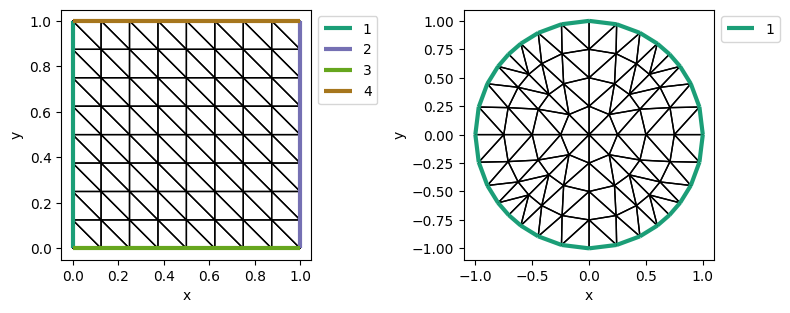

In [32]:
from firedrake import *
import matplotlib.pyplot as plt
from py.intro_utils import plot_mesh_with_label

N = 8
rect_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
circ_mesh = UnitDiskMesh(2)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
plot_mesh_with_label(rect_mesh, axes=ax[0])
plot_mesh_with_label(circ_mesh, axes=ax[1])
fig.tight_layout()

### Set Dirichlet boundary conditions

In [33]:
N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)

g = x*2 + y*2
V = FunctionSpace(test_mesh, 'CG', degree=1)


def trisurf_bdy_condition(V, g, sub_domain, axes=None):
    bc = DirichletBC(V, g=g, sub_domain=sub_domain)
    g = Function(V)
    bc.apply(g)

    trisurf(g, axes=axes)
    if axes:
        axes.set_xlabel('x')
        axes.set_ylabel('y')
        axes.set_title(sub_domain)

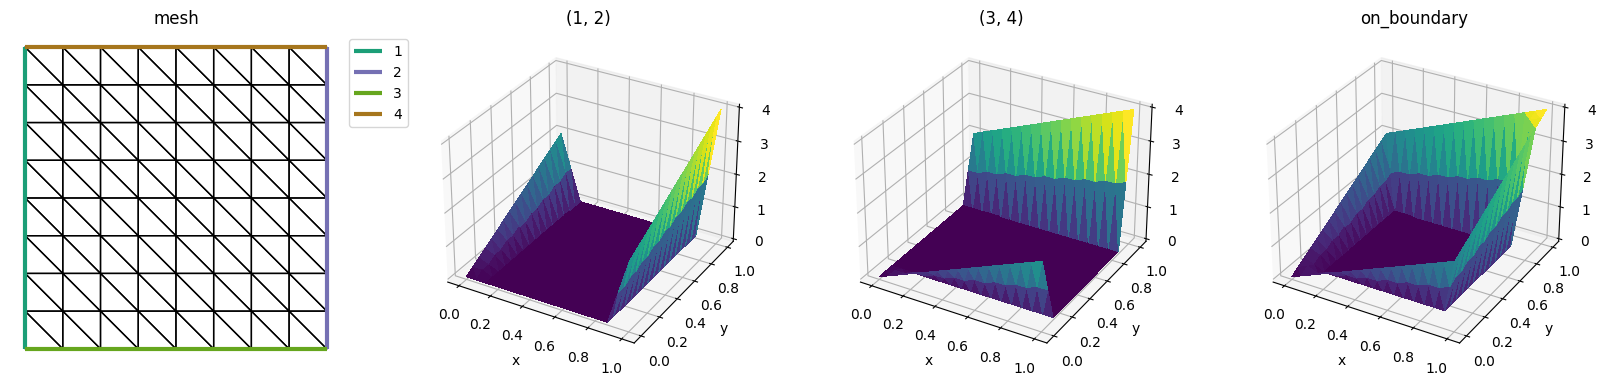

In [34]:
# plot the mesh and boundry conditons
fig, ax = plt.subplots(1, 4, figsize=[16, 4], subplot_kw=dict(projection='3d'))
ax = ax.flat

ax[0].remove()
ax[0] = fig.add_subplot(1, 4, 1)
plot_mesh_with_label(test_mesh, ax[0])
ax[0].set_title('mesh')
ax[0].axis('off')

sub_domains = [(1, 2), (3, 4), 'on_boundary']
for i in range(3):
    trisurf_bdy_condition(V, g=g, sub_domain=sub_domains[i], axes=ax[i+1])
fig.tight_layout()

### `sub_domain` of  `DirichletBC` 

The following comments are copy from `firedrake/bcs.py`
```python
# Define facet, edge, vertex using tuples:
# Ex in 3D:
#           user input                                                         returned keys
# facet  = ((1, ), )                   ->     ((2, ((1, ), )), (1, ()),         (0, ()))
# edge   = ((1, 2), )                  ->     ((2, ()),        (1, ((1, 2), )), (0, ()))
# vertex = ((1, 2, 4), )               ->     ((2, ()),        (1, ()),         (0, ((1, 2, 4), ))
#
# Multiple facets:
# (1, 2, 4) := ((1, ), (2, ), (4,))   ->     ((2, ((1, ), (2, ), (4, ))), (1, ()), (0, ()))
#
# One facet and two edges:
# ((1,), (1, 3), (1, 4))              ->     ((2, ((1,),)), (1, ((1,3), (1, 4))), (0, ()))
```

## [Gmsh](https://gmsh.info/) 网格边界设置

需要在 gmsh 中给相应的边界加上标签 (Physical Tag)

_gmsh gui 演示_: 生成如下 `geo` 文件和 `msh` 文件

File: [`gmsh/rectangle.geo`](gmsh/rectangle.geo)
```text
// Gmsh project created on Tue Sep 30 15:09:53 2022
SetFactory("OpenCASCADE");
//+
Rectangle(1) = {0, 0, 0, 1, 1, 0};
//+
Physical Curve("lower", 1) = {1};
//+
Physical Curve("upper", 2) = {3};
//+
Physical Curve("left", 3) = {4};
//+
Physical Curve("right", 4) = {2};
//+
Physical Surface("domain", 1) = {1};
```

Gmsh file: [`gmsh/rectangle.msh`](gmsh/rectangle.msh)

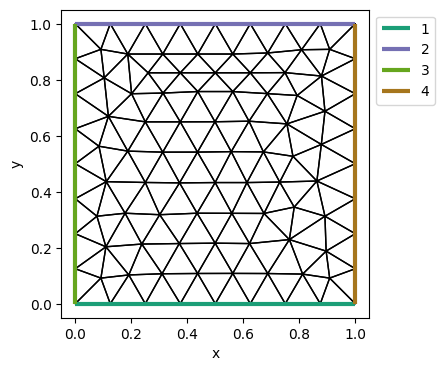

In [35]:
from firedrake import *
from firedrake.petsc import PETSc
from py.intro_utils import plot_mesh_with_label

# opts = PETSc.Options()
# opts.insertString('-dm_plex_gmsh_mark_vertices True')

gmsh_mesh = Mesh('gmsh/rectangle.msh')
plot_mesh_with_label(gmsh_mesh)

_使用 gmsh 的 python SDK_: [gmsh](https://pypi.org/project/gmsh/) 或者 [pygmsh](https://pypi.org/project/pygmsh/)

example: [py/make_mesh_circle_in_rect.py](py/make_mesh_circle_in_rect.py) with [gmsh/circle_in_rect.msh](gmsh/circle_in_rect.msh)

Info    : Writing 'gmsh/circle_in_rect.msh'...
Info    : Done writing 'gmsh/circle_in_rect.msh'


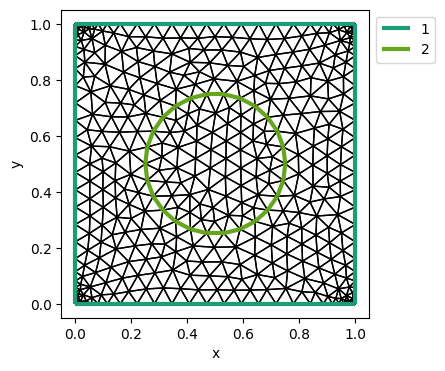

In [36]:
from firedrake import *
from py.intro_utils import plot_mesh_with_label
from py.make_mesh_circle_in_rect import make_circle_in_rect

h = 1/16
filename = 'gmsh/circle_in_rect.msh'
make_circle_in_rect(h, filename, p=3, gui=False)

cr_mesh = Mesh(filename)
plot_mesh_with_label(cr_mesh)

## Neumann boundary condition

求解如下 Poisson 方程
\begin{equation}
\begin{aligned}
- \Delta u &= f   &&\quad{\rm in}\quad \Omega,\\
         \frac{\partial u}{\partial n} &= g_N &&\quad{\rm on} \quad \partial\Omega,
\end{aligned}
\end{equation}

__变分问题__

求 $u \in H^1$, 且 $\int_\Omega u = 0$ 使得
\begin{equation}
    \int_\Omega \nabla u\cdot\nabla v = \int_\Omega f v + \int_{\partial\Omega} g_N v \qquad \forall v \in H^1.
\end{equation}

__兼容性条件__

$$
\int_\Omega f v + \int_{\partial\Omega} g_N v = 0
$$

### Use nullspace of solve

通过 nullspace 求出的解 `u_h` 并不满足积分为 0, 而是其对应的解向量的范数最小, 所以我们需要做后处理得到积分为 0 的解:

```python
s = assemble(u_h*dx)/assemble(Constant(1)*dx(domain=mesh)
u_h.assign(u_h - s)
```

Reference:

1. https://petsc.org/main/manual/ksp/#solving-singular-systems
2. https://petsc.org/main/manualpages/KSP/KSPSolve/
3. https://petsc.org/main/manualpages/Mat/MatSetNullSpace/

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


    Residual norms for test1_ solve.
    0 KSP Residual norm 9.134205437239e-02 
    1 KSP Residual norm 2.635631193496e-13 
    Residual norms for test2_ solve.
    0 KSP Residual norm 9.134205437239e-02 
    1 KSP Residual norm 1.416258567001e-16 


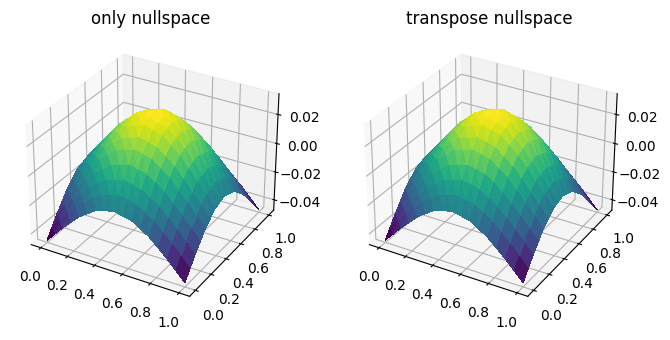

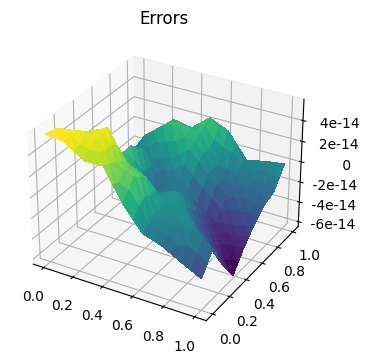

In [ ]:
from firedrake import *
import matplotlib.pyplot as plt

N = 8
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)
x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

subdomain_id = None # None for all boundray, 或者单个编号 如 1, 或者使用 list 或 tuple 如: (1, 2)

if False:
    # 不满足兼容性条件
    g = Constant(1)
else:
    # 满足兼容性条件
    length = assemble(1*ds(domain=test_mesh, subdomain_id=subdomain_id))
    g = Constant(-assemble(f*dx)/length)
    # g = Constant(-1/pi**2)

V = FunctionSpace(test_mesh, 'CG', degree=1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = inner(f, v)*dx + inner(g, v)*ds(subdomain_id=subdomain_id)

u1_h = Function(V, name='u1_h')

nullspace = VectorSpaceBasis(constant=True, comm=test_mesh.comm)

solve(a == L, u1_h, 
      solver_parameters={
          # 'ksp_view': None,
          'ksp_monitor': None,
      },
      options_prefix='test1',
      nullspace=nullspace, 
      transpose_nullspace=None)

u2_h = Function(V, name='u2_h')
solve(a == L, u2_h,
      solver_parameters={
          # 'ksp_view': None,
          'ksp_monitor': None,
      },
      options_prefix='test2',
      nullspace=nullspace, 
      transpose_nullspace=nullspace)

# 通过 nullspace 求出的解并不满足积分为 0, 需要做后处理
omega = assemble(Constant(1)*dx(domain=test_mesh))
s1 = assemble(u1_h*dx)/omega
u1_h.dat.data_with_halos[:] = u1_h.dat.data_ro_with_halos[:] - s1

s2 = assemble(u2_h*dx)/omega
u2_h.dat.data_with_halos[:] = u2_h.dat.data_ro_with_halos[:] - s2

fig, ax = plt.subplots(1, 2, figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts1 = trisurf(u1_h, axes=ax[0])
title1 = ax[0].set_title('only nullspace')
ts2 = trisurf(u2_h, axes=ax[1])
title2 = ax[1].set_title('transpose nullspace')

# plot the error
fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
err = Function(u1_h).assign(u1_h - u2_h)
trisurf(err, axes=ax)
ax.set_title('Errors')

# The z ticklabel do not show properly, when the values are small.
# we set the major formatter to make it show correctly
fmt = lambda x, pos: f'{x:10g}'
ax.zaxis.set_major_formatter(fmt)

# ax.ticklabel_format(axis='z', style='plain') # may work for not too small values

### Using Lagrange multiplier

<!--__极值问题__
求 $u \in H^1 $ 满足
\begin{equation}
\begin{aligned}
    & u = \arg\min J(u)\\
    & J(u) = \frac12\int_\Omega |\nabla u|^2 - \int_\Omega f u - \int_{\partial\Omega} g_N u\\
    &\int_\Omega u = 0
\end{aligned}
\end{equation}

__等价问题__
\begin{equation}
\begin{aligned}
    & u, \mu = \arg\min \tilde J(u, \mu)\\
    & \tilde J(u, \lambda) = J(u) + \mu \int_\Omega u, \quad \mu\in \mathbb{R}\\
\end{aligned}
\end{equation}
-->

__变分问题__

求 $u\in H^1, \mu \in R$ 使得 
\begin{equation}
\begin{aligned}
    & \int_\Omega \nabla u \cdot \nabla v + \mu \int_\Omega v - \int_\Omega f v - \int_{\partial\Omega} g_N v = 0, \quad\forall \in H^1 \\
    & \eta \int_\Omega u = 0,\quad \forall \eta \in \mathbb{R}\\
\end{aligned}
\end{equation}

File: [](py/possion_neumann_lagrange.py)

firedrake:WARNING Real block detected, generating Schur complement elimination PC


Write pvd file: pvd/u_h_neumann.pvd


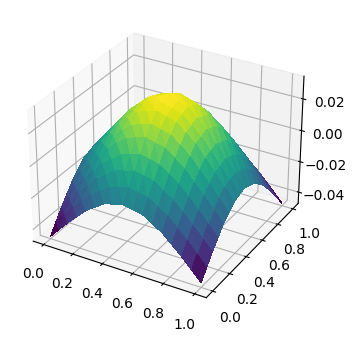

In [ ]:
# %load possion_neumann_lagrange.py
from firedrake import *
from firedrake.petsc import PETSc
import matplotlib.pyplot as plt

opts = PETSc.Options()
N = opts.getInt('N', default=8)
test_mesh = RectangleMesh(nx=N, ny=N, Lx=1, Ly=1)

x, y = SpatialCoordinate(test_mesh)
f = sin(pi*x)*sin(pi*y)

subdomain_id = None
length = assemble(1*ds(domain=test_mesh, subdomain_id=subdomain_id))
g = Constant(-assemble(f*dx)/length)
# g = Constant(-1/pi**2)

V = FunctionSpace(test_mesh, 'CG', degree=1)
R = FunctionSpace(test_mesh, 'R', 0)

W = MixedFunctionSpace([V, R]) # or W = V*R

u, mu = TrialFunction(W)
v, eta = TestFunction(W)

a = inner(grad(u), grad(v))*dx + inner(mu, v)*dx + inner(u, eta)*dx
L = inner(f, v)*dx + inner(g, v)*ds(subdomain_id=subdomain_id)

w_h = Function(W)
solve(a == L, w_h,      
      solver_parameters={
          # 'mat_type': 'nest',
          # 'ksp_view': None,
          # 'pc_type': 'fieldsplit',
          # 'ksp_monitor': None,
      },
      options_prefix='test')

u_h, mu_h  = w_h.subfunctions

filename = 'pvd/u_h_neumann.pvd'
PETSc.Sys.Print(f'Write pvd file: {filename}')
File(filename).write(u_h)

fig, ax = plt.subplots(figsize=[4, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

__终端演示__

```bash
$ python possion_neumann_lagrange.py -test_ksp_monitor -test_ksp_converged_reason -N 64
Number of Dofs: 4226
firedrake:WARNING Real block detected, generating Schur complement elimination PC
    Residual norms for test_ solve.
    0 KSP Residual norm 2.501422711621e-01
    1 KSP Residual norm 1.747929427611e-01
    2 KSP Residual norm 1.071502741145e-14
  Linear test_ solve converged due to CONVERGED_RTOL iterations 2
Write pvd file: pvd/u_h_neumann.pvd

$ mpiexec -n 2 python possion_neumann_lagrange.py \
    -test_ksp_monitor -test_ksp_converged_reason -N 64
Number of Dofs: 4226
firedrake:WARNING Real block detected, generating Schur complement elimination PC
    Residual norms for test_ solve.
    0 KSP Residual norm 2.501422711621e-01
    1 KSP Residual norm 2.085403806063e-02
    2 KSP Residual norm 9.317076546546e-16
  Linear test_ solve converged due to CONVERGED_RTOL iterations 2
Write pvd file: pvd/u_h_neumann.pvd
```